#### NX-414: Brain-like computation and intelligence, Spring 2023

Notebook prepared by Bartlomiej Borzyszkowski

# Week 2 - Learning a sparse code for natural images
### Table of Contents<span class="tocSkip"></span>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#1.-Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Introduction</a></span></li>
    <li><span><a href="#2.-Image-representation" data-toc-modified-id="Image-representation-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Image representation</a></span></li>
    <li><span><a href="#3.-Principal-Components-Analysis-(PCA)" data-toc-modified-id="Principal-Components-Analysis-(PCA)-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Principal Components Analysis (PCA)</a></span></li>
    <li><span><a href="#4.-Sparse-coding-network" data-toc-modified-id="Sparse-coding-network-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Sparse coding network</a></span></li> 
    <li><span><a href="#5.-Run-simulation" data-toc-modified-id="Run-simulation-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Run simulation</a></span></li> 
    <li><span><a href="#6.-Evaluate-performance" data-toc-modified-id="Evaluate-performance-6"><span class="toc-item-num">6.&nbsp;&nbsp;</span>Evaluate performance</a></span></li> 
    <li><span><a href="#7.-Conclusion" data-toc-modified-id="Conclusion-7"><span class="toc-item-num">7.&nbsp;&nbsp;</span>Conclusion</a></span></li>  

### 1. Introduction

In this exercise, we will study a theory for how the visual system might learn to represent visual information. The visual system must extract useful information from the complex and highly redundant visual input it receives. The **receptive fields** of simple cells in the **primary visual cortex (V1)** can be characterized as being **spatially localized**, **oriented**, and **bandpass**. This means that simple cells are sensitive to visual stimuli presented at a specific location and orientation in the visual field. They are also selective for a range of spatial frequencies. 

We aim to understand response properties of visual neurons by considering their relationship to the statistical structure of natural images in terms of efficient coding. To accomplish this, we will consider that the visual system learns a "sparse code" for natural images. A sparse code is one in which only a small number of neurons in V1 are active at any given time, meaning that the neurons only respond to certain features or patterns in the image.

The exercise is based on the work by [Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. Nature, 381(6583), 607–609.](https://www.nature.com/articles/381607a0) 

### 2. Image representation

We start with the assumption that an image $I(x,y)$ can be represented as a linear superposition of (not necessarily
orthogonal) basis functions $\phi_i(x, y)$:

<div style="display: flex; justify-content: center;">

$I(x,y) = \sum_{i} a_i \phi_i(x, y)$

</div>

The image code is determined by the choice of basis functions $\phi_i$. The coefficients $a_i$ are dynamic variables that change from one
image to the next. 

##### Run the code below to import the requirements:   

In [1]:
# import external packages

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io as sio
import cv2

%matplotlib inline

#NOTE: perhaps you need into install cv2:
#!pip install opencv-python


As a warmup, depict a few Gabor filter (also known as Gabor wavelet or kernel). It is a mathematical function that is used in image processing to extract features such as edges and textures from an image and describes simple cells well.


It is a type of filter that combines a Gaussian envelope with a sinusoidal carrier wave. The Gaussian envelope determines the size and shape of the filter, while the carrier wave determines the frequency and orientation of the filter. The equation for a Gabor filter in two dimensions is:


$$G(x, y) = \exp\left(-\frac{x^2 + y^2}{2 σ^2}\right)\cdot \cos(2 π  f  x + \phi)$$


where $x$ and $y$ are the spatial coordinates, $\sigma$ is the standard deviation of the Gaussian function, $u$ and $v$ are the frequency vectors, and $\phi$ is the phase offset.

##### Implement four Gabor filters oriented at 0°, 45°, 90°, and 135° with parameters:
- kernel size = (30, 30);
- Gaussian standard deviation = 3.0;
- wave length = 10;
- spatial ratio = 0.5;
- phase = 0 

In [2]:
kernelwidth = 30 
thetas = np.array([0, 45, 90, 135]) * np.pi / 180
gabor = []

for i, t in enumerate(thetas):
    gabor_kernel = cv2.getGaborKernel(ksize=(kernelwidth, kernelwidth), sigma=3.0, theta=t, lambd=10, gamma=0.5, psi=0)
    gabor.append(gabor_kernel)

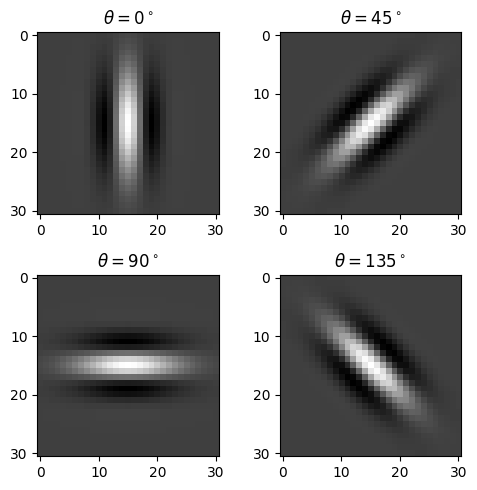

In [3]:
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(gabor[i], cmap="gray")
plt.tight_layout()

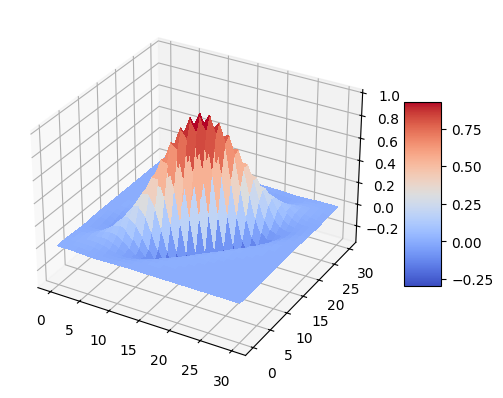

In [4]:
# Interactive 3D plot (as shown in the lecture)
# Note: if the above line fails, try replacing `%matplotlib widget` with `%matplotlib notebook`

from matplotlib import cm

X = np.arange(kernelwidth+1)
Y = np.arange(kernelwidth+1)
X, Y = np.meshgrid(X, Y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, gabor[i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

##### Run the code below to download the dataset: 

In [5]:
# Download the dataset from original paper source at http://www.rctn.org/bruno/sparsenet/
# Note you can also use curl, if wget is not installed (e.g. on MacOS)
#!curl  "-O" "http://www.rctn.org/bruno/sparsenet/IMAGES.mat"
#!curl  "-O" "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"
#!wget "http://www.rctn.org/bruno/sparsenet/IMAGES.mat"
#!wget "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"
mat_images = sio.loadmat('IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

In [6]:
# What are the dimensions?
np.shape(imgs)

(512, 512, 10)

##### Run the code below to visualize raw images from the dataset:

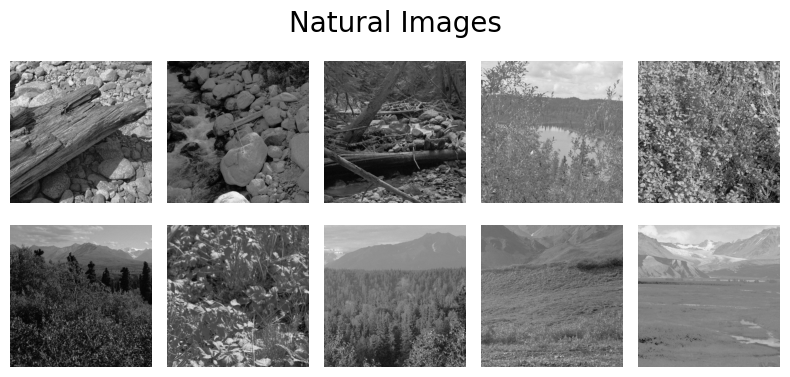

In [7]:
# Plot example natural images

fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9) 
plt.show()

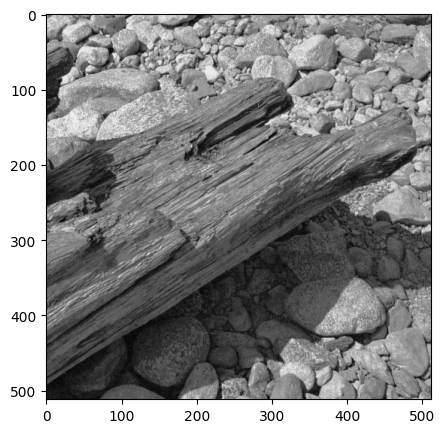

In [8]:
# Display the first image in the dataset
plt.figure(figsize=(5,5))
plt.imshow(imgs_raw[:,:,0], cmap="gray")
plt.show()

##### Apply each of the pre-defined Gabor Kernels to a single image from the dataset and visualize the output

In [9]:
single_image = imgs_raw[:, :, 0]
out = []
for i in range(4):
    out_image = cv2.filter2D(single_image, kernel=gabor[i], ddepth=-1)
    out.append(out_image)

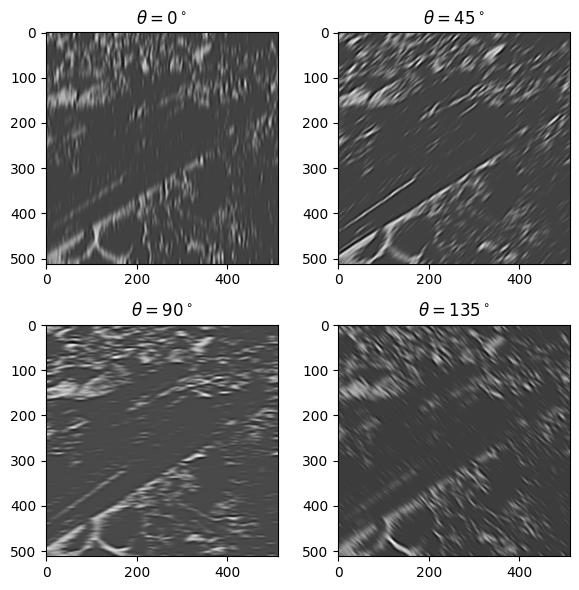

In [10]:
plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.title(r"$\theta=$"+str(i*45)+r"$^\circ$")
    plt.imshow(out[i], cmap="gray")
plt.tight_layout()

In [11]:
# Extract images patches

# Simulation constants
H, W, num_images = imgs_raw.shape
patchs_list = []

# TODO: specify the number of parameters (eg. 15000) and path size (eg. 16 x 16) (~2 lines):
num_patches = 15_000
w, h = 16, 16

pl=[]

# Generate image patches
for patch in tqdm(range(num_patches)):
    # Get the coordinates of the upper left corner of for cropping images randomly.
    beginx = np.random.randint(0, W-w-1)
    beginy = np.random.randint(0, H-h-1)
    
    # Choose a random image
    idx = np.random.randint(0, num_images)
    
    # Crop the randomly chosen image
    img_cropped = imgs_raw[beginy:beginy+h, beginx:beginx+w, idx]    

    patchs_list.append(img_cropped.flatten())
    img_c=imgs[beginy:beginy+h, beginx:beginx+w, idx]
    pl.append(img_c.flatten())
    
processed_patches=np.array(pl)
patches = np.array(patchs_list)

  0%|          | 0/15000 [00:00<?, ?it/s]

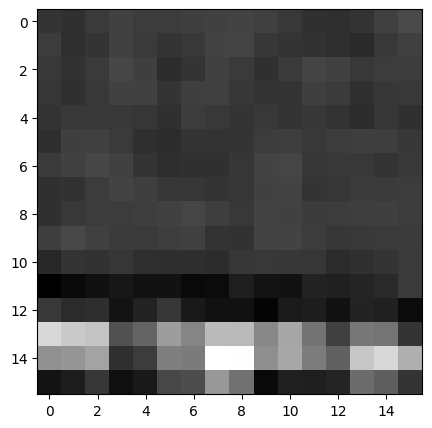

In [12]:
# Examples of patch
plt.figure(figsize=(5,5))
plt.imshow(processed_patches[0].reshape(16,16), cmap="gray")
plt.show()

### 3. Principal Components Analysis (PCA)

Next, we will use Principal Component Analysis (PCA), an unsupervised learning technique used to transform a set of correlated variables into a set of linearly uncorrelated variables called principal components (principal components are orthogonal to each other). PCA is commonly used for dimensionality reduction, feature extraction, and data visualization.

In image processing, PCA can be applied to reduce the dimensionality of an image by projecting it onto a lower-dimensional space, while preserving the most important features of the image. This is achieved by finding a set of principal components that capture the largest amount of variance in the image data (largest singular values). The principal components can be used to reconstruct the original image, or to extract features for image analysis.

The goal is to find a set of mutually orthogonal basis functions that capture the directions of maximum variance in the data and for which the coefficients are pairwise decorrelated, $<a_ia_j> = <a_i><a_j>$.

In [13]:
from sklearn.decomposition import PCA

##### Run the PCA and plot the resulting filters:

  0%|          | 0/25 [00:00<?, ?it/s]

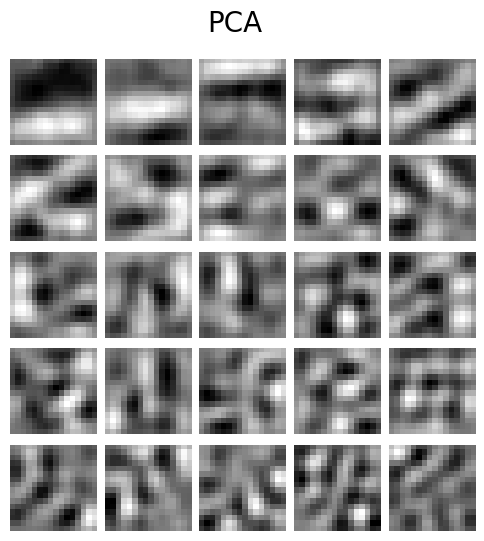

In [14]:
n_comp = 25
pca = PCA(n_components=n_comp)
pca.fit(processed_patches)
pca_filters = pca.components_

plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.reshape(pca_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("PCA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

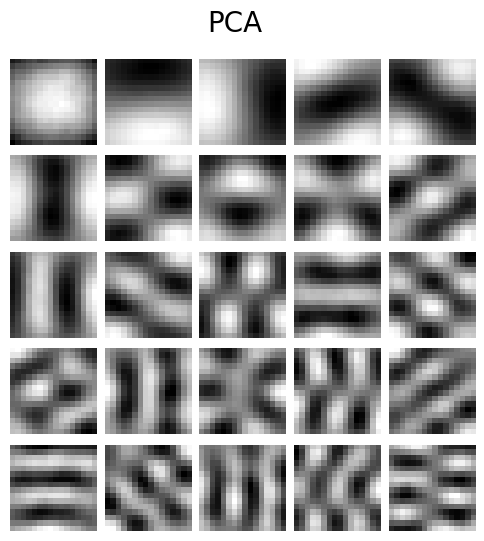

In [15]:
n_comp = 25
pca = PCA(n_components=n_comp)
pca.fit(patches)
pca_filters = pca.components_

plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(n_comp)):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.reshape(pca_filters[i], (w, h)), cmap="gray")
    plt.axis("off")
plt.suptitle("PCA", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

Note that receptive fields found by PCA are not localized and the vast majority do not at all resemble cortical tuning curves.

### 4. Sparse coding network

We will use a computational model to simulate the learning of a sparse code for natural images. We assume that the neurons in V1 initially have random connections to the input, and then update their connections based on a **learning algorithm that encourages sparsity**. 

The search for a sparse code can be formulated as an optimization problem by constructing the following cost function to be
minimized: 

$$
E = \underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{a}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(\frac{a_i}{\sigma}\right)}_{\text{sparseness of}\ a_i} \tag{2}
$$

where $\lambda$ is a positive constant that determines the importance of the second term relative to the first. The first term measures how well the code describes the image, and we choose it to be the mean square of the error between the actual image and the reconstructed image. The second term assesses the sparseness of the code for a given image by assigning a cost depending on how activity is distributed among the coefficients: those representations in which activity is spread over many coefficients should incur a higher cost than those in which only a few coefficients carry the load.

The value of $S(x) = |x|$. The reasoning behind this choice is that they it favours among activity states with equal variance those with the fewest number of non-zero coefficients ($L1$ regularization). 


##### Implement a class for the Sparse Coding Network:
It is a simple neural network with one hidden later. The input is a 16×16 image patch randomly cut out, which is received by 256 neurons in the input layer. Assume that the neurons in the input layer project to 25 neurons in the hidden layer that sparsely encodes the input.

We will train the model using LCA (Local Competitive Algorithm), an update rule with local competition (lateral suppression) and a threshold function. More details on this model can be found in 

Sparse coding via thresholding and local competition in neural circuits by Rozell, Johnson, Baraniuk, and Olshausen
https://pubmed.ncbi.nlm.nih.gov/18439138/

This was also briefly mentioned in the class

In [16]:
class SparseCodingNetwork:
    def __init__(self, num_inputs, num_units, batch_size, lr_a=1e-2, lr_Phi=1e-2, lmda=5e-3):
        # Learning rates
        self.lr_a = lr_a
        self.lr_Phi = lr_Phi
        
        # Regularization parameter
        self.lmda = lmda

        # Other hyperparameters
        self.num_inputs = num_inputs 
        self.num_units = num_units
        self.batch_size = batch_size
        
        # Weights initialization
        Phi = np.random.randn(self.num_inputs, self.num_units).astype(np.float32)
        self.Phi = Phi * np.sqrt(1/self.num_units)
        self.initialize_states()
    
    def initialize_states(self):
        self.a = np.zeros((self.batch_size, self.num_units))
        
    def normalize_rows(self):
        self.Phi = self.Phi / np.maximum(np.linalg.norm(self.Phi, ord=2, axis=0, keepdims=True), 1e-8)

    def soft_thresholding_func(self, x, lmda):
        """ 
        Soft thresholding function of S(x)=|x| 
        """ 
        return np.maximum(x - lmda, 0) - np.maximum(-x - lmda, 0)

    def calculate_total_error(self, error):
        """
        Calculate the cost function
        """
        recon_error = np.mean(error**2)
        sparsity_a = self.lmda*np.mean(np.abs(self.a)) 
        return recon_error + sparsity_a
        
    def __call__(self, inputs, training=True):
        # Updates                
        error = inputs - self.a @ self.Phi.T
        
        a = self.a + self.lr_a * error @ self.Phi
        self.a = self.soft_thresholding_func(a, self.lmda)
        
        if training:  
            error = inputs - self.a @ self.Phi.T
            dPhi = error.T @ self.a
            self.Phi += self.lr_Phi * dPhi
            
        return error, self.a

### 5. Run simulation

##### Specify the simulation constants and initialize the model:

In [17]:
# Simulation constants
H, W, num_images = imgs.shape

# number of iterations (eg. 100) maximum number of simulation time (eg. 1000s) and batch size (eg. 250)
num_iter = 500
nt_max = 1000
batch_size = 250 

# image patch size (eg. 16) and the number of neurons (eg. 25)
sz = 16 
num_units = 25  

num_inputs = sz**2
eps = 1e-2  # small value which determines convergence
error_list = [] # List to save errors

model = SparseCodingNetwork(num_inputs, num_units, batch_size)

##### Implement code to run the simulation:

In [18]:
# Run simulation
for iter_ in tqdm(range(num_iter)):
    # Get the coordinates of the upper left corner of cropping image randomly.
    beginx = np.random.randint(0, W-sz, batch_size)
    beginy = np.random.randint(0, H-sz, batch_size)

    inputs_list = []
    for i in range(batch_size):        
        # Index of a random image
        idx = np.random.randint(0, num_images)
        img = imgs[:, :, idx]
        crop = img[beginy[i]:beginy[i]+sz, beginx[i]:beginx[i]+sz].flatten()
        inputs_list.append(crop - np.mean(crop))
        
    inputs = np.array(inputs_list) # Input image patches
    
    # Reset (initialize) states of the model 
    model.initialize_states()

    # Normalize weights (rows)
    model.normalize_rows()
    
    # Initialize the a (activity of neurons)
    a_tm1 = np.zeros((batch_size, num_units))

    for t in range(nt_max):
        # Update a without update weights (set training to False) 
        error, a = model(inputs, training=False)
        
        # Compute the difference between current and previous a 
        da = a - a_tm1

        # Compute norm of a
        da_norm = np.linalg.norm(da, ord=2) / (eps + np.linalg.norm(a_tm1, ord=2))
        a_tm1 = a # update a_tm1
        
        # Check convergence of a, then update weights
        if da_norm < eps:
            # Update a with weights update (set training to True)
            error, a = model(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if t >= nt_max-2: 
            print("Error at patch:", iter_)
            print(da_norm)
            break
   
    error_list.append(model.calculate_total_error(error)) # Append errors

    # Print moving average error
    if iter_ % 100 == 99:  
        print("iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:", np.mean(error_list[iter_-99:iter_]))

  0%|          | 0/500 [00:00<?, ?it/s]

iter: 100/500, Moving error: 0.06507081560347182
iter: 200/500, Moving error: 0.0633345409260148
iter: 300/500, Moving error: 0.06297660946745824
iter: 400/500, Moving error: 0.06238452841570565
iter: 500/500, Moving error: 0.06291479411111335


### 6. Evaluate performance



##### Run the following code to plot the error across the iterations:

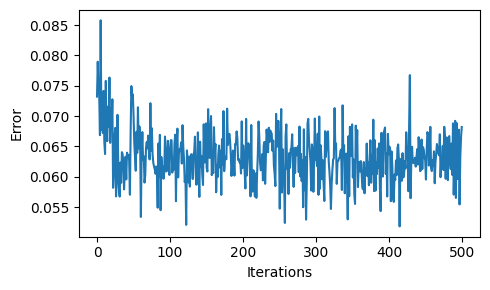

In [19]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), np.array(error_list))
plt.tight_layout()
plt.show()

##### Run the following code to plot the resulting receptive fields:

  0%|          | 0/25 [00:00<?, ?it/s]

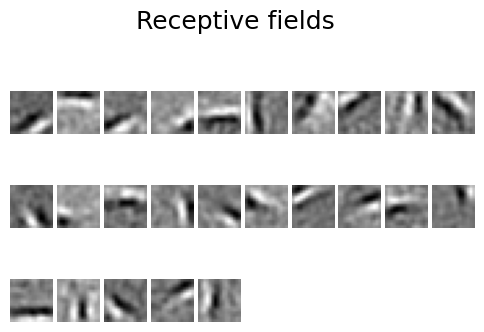

In [20]:
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm(range(num_units)):
    plt.subplot(5, 10, i+1)
    plt.imshow(np.reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=18)
plt.show()

### 7. Conclusion

The presented results show that the sparse model learns to extract simple features from natural images, these receptive fields are similar to the receptive fields of simple cells in the visual cortex. The model provides a plausible explanation for how the visual system might learn to represent complex visual information with a relatively small number of neurons. The result suggests that this type of sparse coding may be a general principle of sensory processing in the brain.

For more detail on this topic, please see the source work by [Olshausen, B. A., & Field, D. J. (1996). Emergence of simple-cell receptive field properties by learning a sparse code for natural images. Nature, 381(6583), 607–609.](https://www.nature.com/articles/381607a0). 

##### Congratulations! You have finished this week's problem set on learning a sparse code for natural images!